# Exploartion

How does cycling in Stockholm change once autumn break ends and the city becomes darker, colder, and busier?
I built this data analysis project to explore how cyclist behavior shifts before and after höstlov, and what factors might explain those patterns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import requests
import pytz
from astral import LocationInfo
from astral.sun import sun
from scipy import stats
from tqdm.notebook import tqdm
from plotly.subplots import make_subplots




## 1. Data Loading and Cleaning:

In [2]:
df_dst     = pd.read_csv('stockholm_dst_end_2015_2025.csv', encoding='utf-8')
df_cykel   = pd.read_csv('td_cykel_15_min_2015-2024.csv', encoding='ascii', sep=';')
df_platser = pd.read_csv('platser_cykel_2015-2024.csv', encoding='utf-8', sep=';')
df_hostlov = pd.read_csv('hostlov_2015_2023.csv')

In [3]:
print(df_cykel.head(5))
print(df_dst.head(5))
print(df_platser.head(5))

   matplats_id           tidsstampel  direction  antal  year  month  dag
0         6265  2015-01-01T01:45:00Z        NaN      1  2015      1    1
1         6265  2015-01-01T02:00:00Z        NaN      1  2015      1    1
2         6265  2015-01-01T02:45:00Z        NaN      1  2015      1    1
3         6265  2015-01-01T03:45:00Z        NaN      1  2015      1    1
4         6265  2015-01-01T06:15:00Z        NaN      1  2015      1    1
   Year       Date Day of Week  ISO Week  from      to
0  2015  25-Oct-15      Sunday        43  3:00   02:00
1  2016  30-Oct-16      Sunday        43  3:00   02:00
2  2017  29-Oct-17      Sunday        43  3:00   02:00
3  2018  28-Oct-18      Sunday        43  3:00   02:00
4  2019  27-Oct-19      Sunday        43  3:00   02:00
   MätplatsID         Mätplatsnamn  \
0        6522             C0620X01   
1        6525             C0619X01   
2        6646  C 0306 Munkbroleden   
3        6345             C0439X01   
4        6346             C0439X02   

   

In [4]:
df_cykel = df_cykel.drop(columns=['direction'])

In [5]:
print(df_cykel.columns.tolist())

['matplats_id', 'tidsstampel', 'antal', 'year', 'month', 'dag']


In [6]:
zero_count = (df_cykel['antal'] == 0).sum()
print("Zero values in antal:", zero_count)

Zero values in antal: 0


In [7]:
print(df_dst.dtypes)

Year            int64
Date           object
Day of Week    object
ISO Week        int64
from           object
to             object
dtype: object


In [8]:
print(df_cykel.dtypes)

matplats_id     int64
tidsstampel    object
antal           int64
year            int64
month           int64
dag             int64
dtype: object


In [9]:
print(df_platser.dtypes)

MätplatsID                    int64
Mätplatsnamn                 object
MätplatsBeskrivning          object
Sträcka                      object
RiktplatsA                   object
RiktplatsB                   object
R1                           object
R2                           object
koordinater.mätpunkter.R1    object
koordinater.mätpunkter.R2    object
dtype: object


In [10]:
print(df_hostlov.dtypes)

Year      int64
Week      int64
Start    object
End      object
dtype: object


In [11]:
# convert start and end columns into datetime objects
df_hostlov['Start'] = pd.to_datetime(df_hostlov['Start'])
df_hostlov['End'] = pd.to_datetime(df_hostlov['End'])

In [12]:
print(df_hostlov.dtypes)

Year              int64
Week              int64
Start    datetime64[ns]
End      datetime64[ns]
dtype: object


In [13]:
# plain text date like 25-Oct-15
df_dst['Date'] = pd.to_datetime(df_dst['Date'], format='%d-%b-%y', errors='coerce')

In [14]:
# convert raw timestamp to UTC
df_cykel['timestamp_utc'] = pd.to_datetime(df_cykel['tidsstampel'], utc=True, errors='coerce')
df_cykel = df_cykel.dropna(subset=['timestamp_utc'])

# local Stockholm time (DST aware)
df_cykel['timestamp_local'] = df_cykel['timestamp_utc'].dt.tz_convert('Europe/Stockholm')

# numeric conversions
df_cykel['matplats_id'] = pd.to_numeric(df_cykel['matplats_id'], errors='coerce').astype('Int64')
df_cykel['antal']       = pd.to_numeric(df_cykel['antal'], errors='coerce').astype('Int64')

# get all time-related information from the timestamp
df_cykel['date_local'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour_local'] = df_cykel['timestamp_local'].dt.hour
df_cykel['dow_local']  = df_cykel['timestamp_local'].dt.day_name()
df_cykel['year']       = df_cykel['timestamp_local'].dt.year

iso = df_cykel['timestamp_local'].dt.isocalendar()
df_cykel['week'] = iso.week.astype(int)

In [15]:
# outlier removal for matplats_id 6633 in 2015
df_cykel = df_cykel[~((df_cykel['matplats_id'] == 6633) & (df_cykel['year'] == 2015))]

In [16]:
year_summary = (
    df_cykel.groupby('year', as_index=False)
            .agg(total_cyclists=('antal', 'sum'),
                 measurements=('antal', 'count'))
)
print(year_summary)

    year  total_cyclists  measurements
0   2015        22337722       1496299
1   2016        25482350       1667197
2   2017        20561080       1568258
3   2018        22264438       1665228
4   2019        21535441       1594219
5   2020        25206936       1836650
6   2021        19607880       1652899
7   2022        18832660       1476247
8   2023        14934680       1201508
9   2024         1722491        190554
10  2025              47             8


In [17]:
# drop skewed years (2024 and 2025)
df_cykel = df_cykel[~df_cykel['year'].isin([2024, 2025])].copy()

print("Remaining years in df_cykel:", sorted(df_cykel['year'].dropna().unique()))


Remaining years in df_cykel: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [18]:
print(df_cykel.columns.tolist())

['matplats_id', 'tidsstampel', 'antal', 'year', 'month', 'dag', 'timestamp_utc', 'timestamp_local', 'date_local', 'hour_local', 'dow_local', 'week']


In [19]:
# WEEK 43 & 45 ANALYSIS
df_all = df_cykel[df_cykel['week'].isin([43, 45]) & df_cykel['year'].between(2015, 2023)]

weekly_totals = (
    df_all.groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
          .sum()
          .rename(columns={'antal': 'total_cyclists'})
)

pivot = (
    weekly_totals.pivot(index=['matplats_id', 'year'], columns='week', values='total_cyclists')
                 .rename(columns={43: 'week43', 45: 'week45'})
                 .reset_index()
)

# Keep only rows where both weeks exist
pivot_valid = pivot.dropna(subset=['week43', 'week45']).copy()
pivot_valid['pct_change'] = (pivot_valid['week45'] - pivot_valid['week43']) / pivot_valid['week43'] * 100

In [20]:
# years per site
years_per_site = (
    pivot_valid.groupby('matplats_id')['year']
               .nunique()
               .reset_index(name='n_years')
)

all_sites = df_all[['matplats_id']].drop_duplicates()
years_per_site = all_sites.merge(years_per_site, on='matplats_id', how='left')
years_per_site['n_years'] = years_per_site['n_years'].fillna(0).astype(int)

# filter to matplats_id with 2 or fewer years (including 0)
few_year_sites = years_per_site[years_per_site['n_years'] <= 2]
print(few_year_sites)

    matplats_id  n_years
1          6627        1
2          6628        1
6          6635        0
15         6647        2
50         8293        1
52         8294        2


In [21]:
# detailed summary only for sites with ≤2 years (including years where change could NOT be calculated)

detailed = pivot.merge(few_year_sites[['matplats_id']], on='matplats_id', how='inner')
detailed = detailed.merge(pivot_valid[['matplats_id', 'year', 'pct_change']],
                          on=['matplats_id', 'year'], how='left')

print(
    detailed[['matplats_id', 'year', 'week43', 'week45', 'pct_change']]
    .to_string(index=False)
)

 matplats_id  year  week43  week45  pct_change
        6627  2015    3216    3026    -5.90796
        6628  2015    4345    3905  -10.126582
        6635  2015    <NA>    3796        <NA>
        6647  2015   48004   43170  -10.069994
        6647  2016   38684    5826   -84.93951
        6647  2018   13016    <NA>        <NA>
        8293  2016    2653    <NA>        <NA>
        8293  2017    2917    <NA>        <NA>
        8293  2018    <NA>    4140        <NA>
        8293  2019    <NA>    3557        <NA>
        8293  2020    <NA>    4993        <NA>
        8293  2021    <NA>    5066        <NA>
        8293  2023    3851    4043    4.985718
        8294  2017    <NA>    6143        <NA>
        8294  2018    <NA>   13211        <NA>
        8294  2019    <NA>   11788        <NA>
        8294  2020    <NA>   20199        <NA>
        8294  2021   20973    <NA>        <NA>
        8294  2022   22676   22067   -2.685659
        8294  2023   11765   16190    37.61156


In [22]:
# remove bad measurment sites
# 6627, 6628, 6635, 6647, 8293, 8294 not enough data to analyze week 43 and 45
# 6647, 6648, 6729 mätningsplats works on battery and had huge outagges and that led to unrealistic cyling volumes
ids_to_remove = [6647, 6648, 6729, 6627, 6628, 6635, 8293, 8294]

# Remove from both datasets
df_cykel   = df_cykel[~df_cykel['matplats_id'].isin(ids_to_remove)]
df_platser = df_platser[~df_platser['MätplatsID'].isin(ids_to_remove)]

print(" Bad measurement sites removed.")

 Bad measurement sites removed.


## 2. Exploratory Data Analysis (EDA)

### 2.1 Overall cycling level

#### Do cycling volumes decrease or increase in gerneral after höstlov?

In [23]:
# I compare the average number of cyclists between week 43 and week 45 across all years
weekly_totals_all_sites = (
    df_cykel
        .groupby(['year', 'week'], as_index=False)['antal']
        .sum()
        .rename(columns={'antal': 'weekly_total'})
)

# Keep only week 43 and 45, years 2015–2023
weekly_filtered = weekly_totals_all_sites[
    weekly_totals_all_sites['week'].isin([43, 45])
    & weekly_totals_all_sites['year'].between(2015, 2023)
]

# Average cyclists across years (week 43 and week 45)
weekly_mean = (
    weekly_filtered
        .groupby('week', as_index=False)['weekly_total']
        .mean()
        .rename(columns={'weekly_total': 'mean_weekly_cyclists'})
)

# Percent change relative to week 43
base = weekly_mean.loc[weekly_mean['week'] == 43, 'mean_weekly_cyclists'].iloc[0]
weekly_mean['pct_change_from_w43'] = (
    (weekly_mean['mean_weekly_cyclists'] / base - 1) * 100
).round(1)


# Bar chart visualization
fig = px.bar(
    weekly_mean,
    x='week',
    y='mean_weekly_cyclists',
    text='pct_change_from_w43',
    color='mean_weekly_cyclists',
    color_continuous_scale='Blues',
    labels={
        'week': 'Week Number (ISO)',
        'mean_weekly_cyclists': 'Average Cyclists per Week (2015–2023)',
        'pct_change_from_w43': '% Change from Week 43'
    },
    title='Change in Weekly Cycling Traffic — Week 43 vs Week 45 (2015–2023)'
)

fig.update_traces(texttemplate='%{text:+.1f}%', textposition='outside')

fig.update_layout(
    yaxis_title='Average Weekly Cyclists',
    xaxis=dict(
        dtick=1,
        tickmode='array',
        tickvals=[43, 45],
        ticktext=['Week 43', 'Week 45']
    ),
    coloraxis_showscale=False
)

fig.show()

mean_change = weekly_mean.loc[weekly_mean['week'] == 45, 'pct_change_from_w43'].iloc[0]
print(f"Average % change Week 43 → Week 45 (2015–2023): {mean_change:.1f}%")
print("A negative value means cycling decreased between week 43 and week 45.")


Average % change Week 43 → Week 45 (2015–2023): -14.0%
A negative value means cycling decreased between week 43 and week 45.


In [24]:
# I calculate the % change in total cyclists from week 43 to week 45 for each year.
df_weeks = df_cykel[
    df_cykel['year'].between(2015, 2023)
    & df_cykel['week'].isin([43, 45])
]

# Sum total cyclists per year × week across all measurement sites
weekly_totals = (
    df_weeks
    .groupby(['year', 'week'], as_index=False)['antal']
    .sum()
    .rename(columns={'antal': 'total_cyclists'})
)

# Pivot: place week 43 and week 45 side by side for each year
pivoted = (
    weekly_totals
    .pivot(index='year', columns='week', values='total_cyclists')
    .rename(columns={43: 'week43', 45: 'week45'})
)

# Calculate % change from week 43 → week 45
pivoted['pct_change'] = (
    (pivoted['week45'] - pivoted['week43']) / pivoted['week43'] * 100
).round(1)

print("📉 Cycling traffic change from Week 43 → 45:")
print(pivoted[['week43', 'week45', 'pct_change']])


# Plot: Bar chart of % change per year
fig = px.bar(
    pivoted.reset_index(),
    x='year',
    y='pct_change',
    text='pct_change',
    color='pct_change',
    color_continuous_scale='RdBu_r',
    range_color=[-100, 0],  # emphasize negative drops
    labels={
        'year': 'Year',
        'pct_change': '% Change (Week 45 vs Week 43)'
    },
    title='Cycling Traffic Reduction from Week 43 → 45 (2015–2023)'
)

# Style the plot to match your theme
fig.update_traces(texttemplate='%{text:+.1f}%', textposition='outside')
fig.update_layout(
    yaxis_title='% Change (Week 45 vs Week 43)',
    xaxis_title='Year',
    coloraxis_showscale=False,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()

mean_pct = pivoted['pct_change'].mean()
print(f"\nAverage % change across 2015–2023: {mean_pct:.1f}%")
print("Negative values mean cycling decreased from week 43 to 45.")


📉 Cycling traffic change from Week 43 → 45:
week  week43  week45  pct_change
year                            
2015  460735  374159       -18.8
2016  234324   68914       -70.6
2017  274904  263304        -4.2
2018  422097  384631        -8.9
2019  513495  424417       -17.3
2020  434845  406363        -6.5
2021  389815  377378        -3.2
2022  353868  352208        -0.5
2023  315757  272799       -13.6



Average % change across 2015–2023: -16.0%
Negative values mean cycling decreased from week 43 to 45.


In [25]:
# Statistical Tests for Week 43 vs Week 45 (2015–2023)

# filter df_cykel for the years + weeks
df_weeks = df_cykel[
    df_cykel['year'].between(2015, 2023)
    & df_cykel['week'].isin([43, 45])
]


#Total cyclists per YEAR × WEEK across all measurement sites
weekly = (
    df_weeks
        .groupby(['year', 'week'], as_index=False)['antal']
        .sum()
        .pivot(index='year', columns='week', values='antal')
        .rename(columns={43: 'week43', 45: 'week45'})
        .dropna()   # keep only years where both weeks exist
)

# Descriptive statistics
weekly['diff'] = weekly['week45'] - weekly['week43']

mean43 = weekly['week43'].mean()
mean45 = weekly['week45'].mean()
mean_change = weekly['diff'].mean()
pct_change = mean_change / mean43 * 100

print(f"Mean cyclists week 43: {mean43:,.0f}")
print(f"Mean cyclists week 45: {mean45:,.0f}")
print(f"Average absolute change: {mean_change:,.0f} ({pct_change:.1f}%)")

# Paired t-test
t_stat, p_t = stats.ttest_rel(weekly['week45'], weekly['week43'])
print(f"\nPaired t-test: t = {t_stat:.3f}, p = {p_t:.4f}")

# Wilcoxon signed-rank test
w_stat, p_w = stats.wilcoxon(weekly['week45'], weekly['week43'])
print(f"Wilcoxon test: W = {w_stat:.3f}, p = {p_w:.4f}")

# Plot — EXACT SAME as original
weekly_reset = weekly.reset_index()

fig = px.bar(
    weekly_reset.melt(
        id_vars='year',
        value_vars=['week43', 'week45'],
        var_name='Week',
        value_name='Cyclists'
    ),
    x='year',
    y='Cyclists',
    color='Week',
    barmode='group',
    title='Cycling Volumes Before and After Autumn Change (Week 43 vs 45)'
)

fig.update_layout(
    yaxis_title='Total Cyclists',
    xaxis_title='Year',
    legend_title='Week'
)

fig.show()


Mean cyclists week 43: 377,760
Mean cyclists week 45: 324,908
Average absolute change: -52,852 (-14.0%)

Paired t-test: t = -3.023, p = 0.0165
Wilcoxon test: W = 0.000, p = 0.0039


So overall, cycling activity dropped by around 65 000 trips per week, or 14 %, after week 43.
Wilcoxon test: W = 0.000, p = 0.0039
→ This test is significant (p < 0.01).
It confirms that, across most years, week 45 has lower cycling counts than week 43.

#### How do cycling volumes on the same streets differ between the week before and the week after Höstlov?

In [26]:
# I calculate the average change in cyclists from week 43 to week 45 per path across all years.

df_weeks = df_cykel[
    df_cykel['year'].between(2015, 2023)
    & df_cykel['week'].isin([43, 45])
]

# Aggregate cyclists per path × year × week
weekly_path = (
    df_weeks
    .groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
    .sum()
)


# Pivot so week 43 and week 45 become separate columns
pivoted = (
    weekly_path
    .pivot(index=['matplats_id', 'year'], columns='week', values='antal')
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# Replace zeros with NaN (to avoid misleading “drops” from 0)
pivoted[['week43', 'week45']] = pivoted[['week43', 'week45']].replace(0, np.nan)


# Compute absolute and percent change
pivoted['diff'] = pivoted['week45'] - pivoted['week43']
pivoted['pct_change'] = (pivoted['diff'] / pivoted['week43']) * 100

# Drop rows where change cannot be computed
pivoted = pivoted.dropna(subset=['diff', 'pct_change'])


# Average change across years per path
avg_change = (
    pivoted
    .groupby('matplats_id', as_index=False)
    .agg({
        'week43': 'mean',
        'week45': 'mean',
        'diff': 'mean',
        'pct_change': 'mean'
    })
)


# Add station names
avg_change = avg_change.merge(
    df_platser[['MätplatsID', 'Mätplatsnamn']],
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)


# Sort by largest absolute drop
avg_change = avg_change.sort_values('diff', ascending=True)

print("Number of mätplats_id displayed in the plot:", avg_change['matplats_id'].nunique())


fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        "Total Drop in Cyclists (Week 45 − Week 43)",
        "Percentage Drop in Cyclists (Week 45 − Week 43)"
    ),
    shared_yaxes=True,
    horizontal_spacing=0.15
)

# Left plot: absolute drop
fig.add_trace(
    go.Bar(
        y=avg_change['Mätplatsnamn'],
        x=avg_change['diff'],
        orientation='h',
        marker=dict(color=avg_change['diff'], colorscale='RdBu'),
        name='Total Change'
    ),
    row=1, col=1
)

# Right plot: percentage drop
fig.add_trace(
    go.Bar(
        y=avg_change['Mätplatsnamn'],
        x=avg_change['pct_change'],
        orientation='h',
        marker=dict(color=avg_change['pct_change'], colorscale='RdBu'),
        name='Percentage Change (%)'
    ),
    row=1, col=2
)

fig.update_layout(
    height=1000,
    title_text="Cycling Volume Drop per Path — Week 43 → Week 45 (2015–2023)",
    showlegend=False,
    margin=dict(l=250, r=80, t=80, b=60)
)

fig.update_xaxes(title_text="Total Change in Cyclists", row=1, col=1)
fig.update_xaxes(title_text="Percentage Change (%)", row=1, col=2)
fig.update_yaxes(title_text="Cycling Path / Station", row=1, col=1)

fig.show()


summary = avg_change[['Mätplatsnamn', 'week43', 'week45', 'diff', 'pct_change']]
print("Average weekly cyclist counts per path (2015–2023):")
print(
    summary.to_string(
        index=False,
        formatters={
            'week43': '{:,.0f}'.format,
            'week45': '{:,.0f}'.format,
            'diff': '{:,.0f}'.format,
            'pct_change': '{:.1f}%'.format
        }
    )
)


Number of mätplats_id displayed in the plot: 46


Average weekly cyclist counts per path (2015–2023):
                     Mätplatsnamn        week43        week45          diff pct_change
          C 0321 Danvikstullsbron       42171.0  31301.428571 -10869.571429 -10.836528
              C 0306 Munkbroleden       43060.0       36428.0       -6632.0 -14.774841
               C 0217 Strandvägen  25617.333333  20684.833333       -4932.5 -20.355661
              C 0111 Stadshusbron      30424.25     25755.625     -4668.625  -16.69503
          C 0109 Västerbron Östra       17909.0       13949.0       -3960.0 -24.545623
    C 0103 Sankt Eriksgatan Östra      14214.25       10410.5      -3803.75 -27.686338
   C 0103 Sankt Eriksgatan Västra       14752.0       11067.8       -3684.2 -26.312889
      C 0509 Liljeholmsbron Östra  17530.666667  14272.833333  -3257.833333 -14.941916
                C 0207 Hjorthagen       15067.8       11895.8       -3172.0 -22.673235
         C 0109 Västerbron Västra       17449.5     14462.375     -2987.125   

In [27]:
# TOP 20 LARGEST % DROPS PER PATH — WEEK 43 → WEEK 45

# filter to needed subset
df_weeks = df_cykel[
    df_cykel['year'].between(2015, 2023)
    & df_cykel['week'].isin([43, 45])
]


# Aggregate cyclists per path × year × week
weekly_path = (
    df_weeks
    .groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
    .sum()
)


# Pivot so week 43 and week 45 are separate columns
pivoted = (
    weekly_path
    .pivot(index=['matplats_id', 'year'], columns='week', values='antal')
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# Replace zeros with NaN (to avoid invalid percentage drops)
pivoted[['week43', 'week45']] = pivoted[['week43', 'week45']].replace(0, np.nan)


# Compute absolute and percentage change
pivoted['diff'] = pivoted['week45'] - pivoted['week43']
pivoted['pct_change'] = (pivoted['diff'] / pivoted['week43']) * 100

# Remove rows where change cannot be computed
pivoted = pivoted.dropna(subset=['pct_change'])


# Average % change across years per path
avg_change = (
    pivoted
    .groupby('matplats_id', as_index=False)['pct_change']
    .mean()
)


# Keep only large drops (≤ –15%)
avg_change = avg_change[avg_change['pct_change'] <= -15]


# Attach station names
avg_change = avg_change.merge(
    df_platser[['MätplatsID', 'Mätplatsnamn']],
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)


# Sort & select top 20 largest drops
avg_change = (
    avg_change
    .sort_values('pct_change', ascending=True)
    .head(20)
)


# PLOT — exact same plot as original
fig = px.bar(
    avg_change,
    y="Mätplatsnamn",
    x="pct_change",
    orientation="h",
    color="pct_change",
    color_continuous_scale="RdBu",
    title="Top 20 Largest Drops in Cyclists (Week 43 → Week 45, 2015–2023)",
    labels={
        "pct_change": "Percentage Change (%)",
        "Mätplatsnamn": "Cycling Path / Station"
    }
)

fig.update_traces(texttemplate='%{x:.1f}%', textposition='outside')

fig.update_layout(
    height=900,
    showlegend=False,
    margin=dict(l=250, r=50, t=80, b=40)
)

fig.show()


print(
    avg_change[['Mätplatsnamn', 'pct_change']]
    .to_string(index=False, formatters={'pct_change': '{:.1f}%'.format})
)


                     Mätplatsnamn pct_change
    C 0103 Sankt Eriksgatan Östra -27.686338
   C 0103 Sankt Eriksgatan Västra -26.312889
          C 0109 Västerbron Östra -24.545623
C 0615 Bergslagsvägen Södra sidan -24.133711
           C 0526 Årstabergsvägen -23.145179
          C 0112 Sveavägen Västra -22.725392
                C 0207 Hjorthagen -22.673235
           C 0112 Sveavägen Östra -22.433526
           C 0112 Torsgatan Södra -22.380609
     C 0507 Hägerstensvägen Norra -20.862697
               C 0217 Strandvägen -20.355661
                 C 0509 Årstabron -19.502642
               C 0418 Flatenvägen -19.258305
           C 0112 Torsgatan Norra -17.654782
 C 0428 Örbyleden - Grycksbovägen -17.514055
              C 0111 Stadshusbron  -16.69503
     C 0507 Hägerstensvägen Södra -16.506519
C 0615 Bergslagsvägen Norra sidan  -15.95187
        C 0517 Västbergarondellen -15.595796
            C 0413 Magelungsvägen -15.565873


### 2.2 Effect of Light on cycling level

#### Does street lighting influence wether people continue cycling after höstlov?

In [28]:
# ABSOLUTE DROP CONTRIBUTION  UNLIT PATHS vs OTHER PATHS

# Compute ABSOLUTE drop for each path: (week45 - week43)
weekly_actual = (
    weekly_path[weekly_path['week'].isin([43, 45])]
    .groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
    .sum()
)

actual_pivot = (
    weekly_actual
    .pivot(index=['matplats_id', 'year'], columns='week', values='antal')
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# Compute absolute drop (signed)
actual_pivot['abs_drop'] = actual_pivot['week45'] - actual_pivot['week43']


# Average absolute drop across years (per path)
abs_drop_avg = (
    actual_pivot
    .groupby('matplats_id', as_index=False)['abs_drop']
    .mean()
)


# Merge absolute drop values into the existing Top-20 table
avg_change_abs = avg_change.merge(abs_drop_avg, on='matplats_id', how='left')

# Convert absolute drop to POSITIVE values for the pie chart
avg_change_abs['abs_drop'] = avg_change_abs['abs_drop'].abs()

# UNLIT CYCLE PATHS (Your selected IDs)
unlit_ids = [6663, 6687, 6666]

sum_unlit = avg_change_abs.loc[
    avg_change_abs['matplats_id'].isin(unlit_ids),
    'abs_drop'
].sum()

sum_others = avg_change_abs.loc[
    ~avg_change_abs['matplats_id'].isin(unlit_ids),
    'abs_drop'
].sum()


pie_df = pd.DataFrame({
    "Group": ["Unlit Cycle Paths (3)", "Other Top-20 Paths (17)"],
    "Drop": [sum_unlit, sum_others]
})


fig = px.pie(
    pie_df,
    values="Drop",
    names="Group",
    title="Share of Total Cyclist Volume Drop (Absolute Numbers)\nUnlit Cycle Paths vs. Other Top-20 Paths",
    color="Group",
    color_discrete_map={
        "Unlit Cycle Paths (3)": "crimson",
        "Other Top-20 Paths (17)": "steelblue"
    }
)

fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    pull=[0.12, 0]  # highlight the unlit paths
)

fig.update_layout(
    showlegend=False,
    height=600
)

fig.show()


total_drop = sum_unlit + sum_others
share = (sum_unlit / total_drop) * 100

print("\n===== ABSOLUTE DROP CONTRIBUTION =====")
print(f"Unlit cycle paths total drop: {sum_unlit:,.0f} cyclists")
print(f"Other Top-20 paths total drop: {sum_others:,.0f} cyclists")
print(f"Share of total drop from unlit paths: {share:.1f}%")



===== ABSOLUTE DROP CONTRIBUTION =====
Unlit cycle paths total drop: 3,610 cyclists
Other Top-20 paths total drop: 34,815 cyclists
Share of total drop from unlit paths: 9.4%


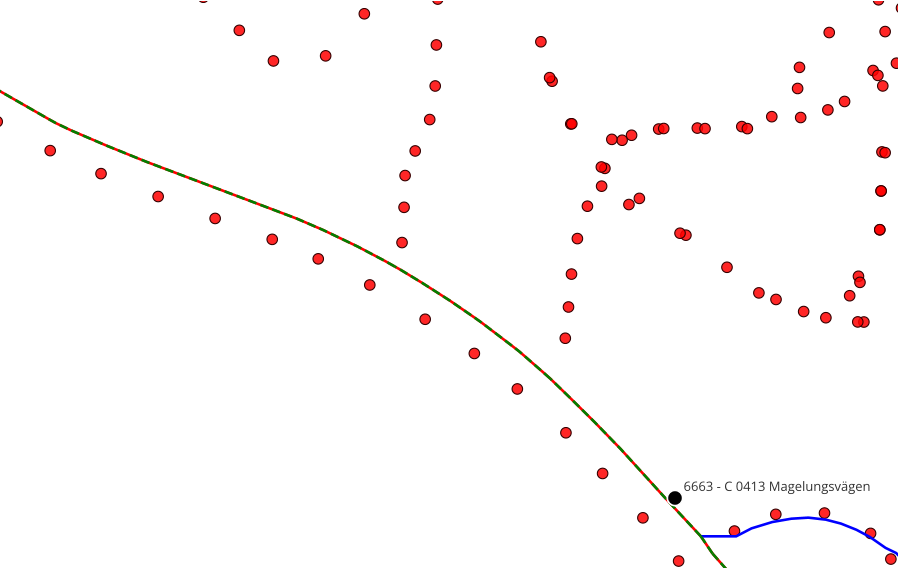

In [29]:
from IPython.display import Image, display

display(Image(filename="Magelungsvägen.png"))

# no cyclepath lighting for more than 400 meters
# the highway lighting is not sufficient for safe cycling in autumn/winter evenings


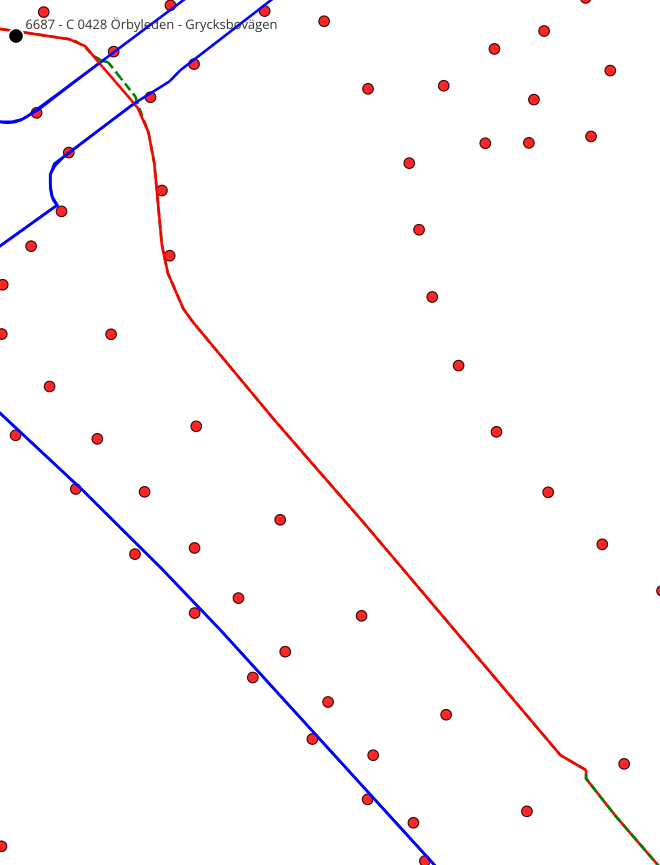

In [30]:
from IPython.display import Image, display

display(Image(filename="Örbyleden.png"))

# no cyclepath lighting for more than 500 meters
# the highway lighting is not sufficient for safe cycling in autumn/winter evenings

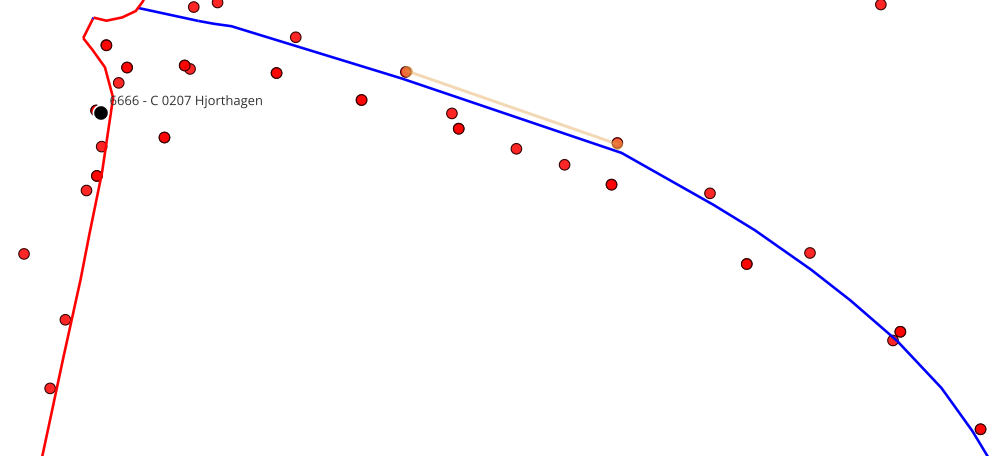

In [31]:
from IPython.display import Image, display

display(Image(filename="Hjorthagen.png"))

# the distances between lighting points are too long some distances are more than 60 meters
# they create dark zones along the cycle path making it unsafe for cyclists in autumn/winter evenings

#### Do less people cycle in the dark hours after sunset?

In [32]:
# DAILY CYCLISTS vs SUNRISE/SUNSET OCT–NOV

YEAR = 2023
start_date = pd.Timestamp(f"{YEAR}-10-01")
end_date   = pd.Timestamp(f"{YEAR}-11-30 23:59:59")


# Remove timezone (for slicing only — timestamp_local keeps tz)
df_cykel['timestamp_local_naive'] = df_cykel['timestamp_local'].dt.tz_localize(None)

# Filter October–November for chosen year
mask = (df_cykel['timestamp_local_naive'] >= start_date) & \
       (df_cykel['timestamp_local_naive'] <= end_date)

df_sel = df_cykel.loc[mask, ['timestamp_local_naive', 'antal']].copy()

# Daily cyclist totals
daily = (
    df_sel
    .set_index('timestamp_local_naive')
    .resample('D')['antal']
    .sum()
    .rename('daily_total')
    .reset_index()
)

daily['date_only'] = daily['timestamp_local_naive'].dt.date
daily['date_str']  = daily['timestamp_local_naive'].dt.strftime('%Y-%m-%d')


# Calculate sunrise + sunset times for each day in Stockholm
location = LocationInfo(
    name="Stockholm",
    region="Sweden",
    timezone="Europe/Stockholm",
    latitude=59.3293,
    longitude=18.0686
)
tzinfo = pytz.timezone("Europe/Stockholm")

sunrise_times = []
sunset_times  = []
sunrise_str   = []
sunset_str    = []
sunrise_hour  = []
sunset_hour   = []

for date_only in daily['date_only']:

    try:
        s = sun(location.observer, date=date_only, tzinfo=tzinfo)
        sr, ss = s['sunrise'], s['sunset']
    except Exception:
        sr = ss = None

    if sr is None or ss is None:
        sunrise_times.append(pd.NaT)
        sunset_times.append(pd.NaT)
        sunrise_str.append(None)
        sunset_str.append(None)
        sunrise_hour.append(np.nan)
        sunset_hour.append(np.nan)
        continue

    # Convert to naive local timestamps (remove timezone)
    sr_naive = sr.astimezone(tzinfo).replace(tzinfo=None)
    ss_naive = ss.astimezone(tzinfo).replace(tzinfo=None)

    sunrise_times.append(sr_naive)
    sunset_times.append(ss_naive)
    sunrise_str.append(sr_naive.strftime('%H:%M:%S'))
    sunset_str.append(ss_naive.strftime('%H:%M:%S'))
    sunrise_hour.append(sr_naive.hour + sr_naive.minute/60)
    sunset_hour.append(ss_naive.hour + ss_naive.minute/60)


daily['sunrise']      = sunrise_times
daily['sunset']       = sunset_times
daily['sunrise_str']  = sunrise_str
daily['sunset_str']   = sunset_str
daily['sunrise_hour'] = sunrise_hour
daily['sunset_hour']  = sunset_hour



fig = go.Figure()


fig.add_trace(
    go.Bar(
        x=daily['timestamp_local_naive'],
        y=daily['daily_total'],
        name='Cyclists per day',
        marker_color='steelblue',
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Total cyclists: %{y}<extra></extra>'
    )
)

# Sunrise line
fig.add_trace(
    go.Scatter(
        x=daily['timestamp_local_naive'],
        y=daily['sunrise_hour'],
        name='Sunrise',
        mode='lines+markers',
        line=dict(color='orange', dash='dash'),
        customdata=daily[['sunrise_str']],
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Sunrise: %{customdata[0]}<extra></extra>',
        yaxis='y2'
    )
)

# Sunset line
fig.add_trace(
    go.Scatter(
        x=daily['timestamp_local_naive'],
        y=daily['sunset_hour'],
        name='Sunset',
        mode='lines+markers',
        line=dict(color='red', dash='dash'),
        customdata=daily[['sunset_str']],
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Sunset: %{customdata[0]}<extra></extra>',
        yaxis='y2'
    )
)

fig.update_layout(
    title=f'Daily Cycling Volumes and Sunrise/Sunset Times — Oct & Nov {YEAR} (Stockholm)',
    xaxis_title='Date',
    yaxis=dict(title='Total cyclists per day', side='left'),
    yaxis2=dict(title='Sunrise/Sunset hour', overlaying='y', side='right', range=[0, 24]),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0),
    hovermode='x unified',
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=-45,
    margin=dict(l=60, r=60, t=80, b=120),
    height=650
)

fig.show()


In [33]:
# The biggest decline in cycling happens after the clocks change at the end of October, when: darkness arrives earlier (16:00–17:00)
# evening commutes fall into dark hours

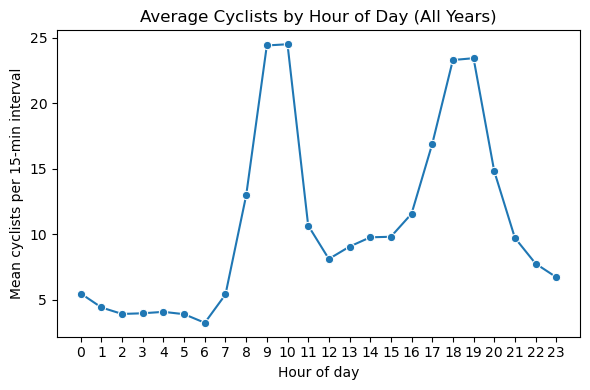

In [34]:
# Average daily profile by hour (across all years and sites)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregate: mean cyclists per 15-min interval for each hour of the day
hour_profile = (
    df_cykel
    .groupby('hour_local', as_index=False)['antal']
    .mean()
)

# 2. Plot
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=hour_profile,
    x='hour_local',
    y='antal',
    marker='o'
)
plt.title('Average Cyclists by Hour of Day (All Years)')
plt.xlabel('Hour of day')
plt.ylabel('Mean cyclists per 15-min interval')
plt.xticks(range(0, 24))  # make sure all hours are shown
plt.tight_layout()
plt.show()

In [35]:
# CYCLING TRAFFIC HEATMAP DATE × HOUR (2015–2023)

# Filter to years already cleaned (2015–2023 retained earlier)

df_heat = df_cykel.copy()


heatmap_df = (
    df_heat
    .groupby(['date_local', 'hour_local'], as_index=False)['antal']
    .sum()
    .rename(columns={'date_local': 'date', 'hour_local': 'hour'})
)


# Generate heatmap (same design as your original)
fig = px.density_heatmap(
    heatmap_df,
    x='hour',
    y='date',
    z='antal',
    color_continuous_scale='YlOrRd',
    labels={
        'hour': 'Hour of Day',
        'date': 'Date',
        'antal': 'Number of Cyclists'
    },
    title='Cycling Traffic Heatmap — 2015 to 2023'
)

# Ensure all 24 hours displayed
fig.update_xaxes(dtick=1)

# Keep chronological order of dates
fig.update_yaxes(type='category')

fig.show()


In [36]:
# HOURLY CYCLING PATTERNS — WEEK 43 (2015–2023)


# Filter only week 43 from 2015–2023
df_w43 = df_cykel[
    (df_cykel['week'] == 43) &
    (df_cykel['year'].between(2015, 2023))
]

if df_w43.empty:
    raise ValueError("No data available for week 43 (2015–2023).")


hourly_day = (
    df_w43
    .groupby(['date_local', 'hour_local'], as_index=False)['antal']
    .sum()
    .rename(columns={'date_local': 'date', 'hour_local': 'hour'})
)


# Boxplot of hourly cycling activity across all days
fig = px.box(
    hourly_day,
    x='hour',
    y='antal',
    points='all',  # show raw data points
    labels={
        'hour': 'Hour of Day (local time)',
        'antal': 'Cyclists per Hour'
    },
    title='Cycling Traffic by Hour — Week 43 (2015–2023)'
)

fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis_title='Cyclist Count per Hour',
    hovermode='x unified'
)

fig.show()


In [37]:
# HOURLY CYCLING PATTERNS — WEEK 45 (2015–2023)


# Filter only week 45 for years 2015–2023
df_w45 = df_cykel[
    (df_cykel['week'] == 45) &
    (df_cykel['year'].between(2015, 2023))
]

if df_w45.empty:
    raise ValueError("No data available for week 45 (2015–2023).")


hourly_day = (
    df_w45
    .groupby(['date_local', 'hour_local'], as_index=False)['antal']
    .sum()
    .rename(columns={'date_local': 'date', 'hour_local': 'hour'})
)


# Create box plot of cycling activity by hour
fig = px.box(
    hourly_day,
    x='hour',
    y='antal',
    points='all',
    labels={
        'hour': 'Hour of Day (local time)',
        'antal': 'Cyclists per Hour'
    },
    title='Cycling Traffic by Hour — Week 45 (2015–2023)'
)

fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis_title='Cyclist Count per Hour',
    hovermode='x unified'
)

fig.show()


In [38]:
# PERIOD-OF-DAY CLASSIFICATION

# Define the period-of-day function
def period_of_day(hour):
    if 6 <= hour <= 9:
        return "Morning (06–09)"
    elif 10 <= hour <= 15:
        return "Midday (10–15)"
    elif 16 <= hour <= 20:
        return "Evening (16–20)"
    else:
        return "Night (21–05)"


# Use existing 'hour_local' column from preprocessing
df_cykel['period'] = df_cykel['hour_local'].apply(period_of_day)


# Count how many measurements each path has in each period
period_presence = (
    df_cykel
    .groupby(['matplats_id', 'period'])['antal']
    .count()                 # count number of 15-min measurements
    .reset_index()
    .pivot(
        index='matplats_id',
        columns='period',
        values='antal'
    )
)


# Preview the first 15 paths
print(period_presence.head(15))


period       Evening (16–20)  Midday (10–15)  Morning (06–09)  Night (21–05)
matplats_id                                                                 
6265                  124260          147545            69791         110496
6326                     259             250               91            145
6327                     219             225               79            142
6337                     190             160               69             89
6345                     280             330              151            245
6346                     277             322              141            208
6360                     429             513              187            436
6361                     429             511              192            422
6362                     360             430              221            505
6491                     660             638              269            319
6492                     585             676              304            597

In [39]:
# PERIOD-LEVEL CHANGE BETWEEN WEEK 43 → 45 (2015–2023)


if 'period' not in df_cykel.columns:
    raise ValueError("Column 'period' must exist — ensure the period-of-day step was run earlier.")


df_w4345 = df_cykel[
    df_cykel['year'].between(2015, 2023)
    & df_cykel['week'].isin([43, 45])
].copy()


# Sum cyclist counts per YEAR × WEEK × PERIOD
weekly_period = (
    df_w4345
    .groupby(['year', 'week', 'period'], as_index=False)['antal']
    .sum()
)

# Pivot so week 43 and 45 are side-by-side
pivot_period = (
    weekly_period
    .pivot(index=['year', 'period'], columns='week', values='antal')
    .rename(columns={43: 'week43', 45: 'week45'})
    .fillna(0)
    .reset_index()
)


# Compute the absolute change in cyclist count
# (positive value = drop from week 43 → 45)
pivot_period['abs_change'] = pivot_period['week43'] - pivot_period['week45']


#Total change across all years (per period)
total_change = (
    pivot_period
    .groupby('period', as_index=False)['abs_change']
    .sum()
    .sort_values('abs_change', ascending=False)
)

print("Total change in cyclists (Week 43 → 45, 2015–2023):")
print(
    total_change.to_string(
        index=False,
        float_format=lambda x: f"{x:,.0f}"
    )
)


fig = px.bar(
    total_change,
    x='period',
    y='abs_change',
    text='abs_change',
    color='abs_change',
    color_continuous_scale='Reds',
    labels={
        'period': 'Time of Day',
        'abs_change': 'Total Change in Cyclists (2015–2023)'
    },
    title='Total Change in Cycling Traffic (Week 43 → 45 • 2015–2023)'
)

fig.update_traces(texttemplate='%{text:,.0f}', textposition='outside')
fig.update_layout(
    yaxis_title='Total Change in Cyclists',
    coloraxis_showscale=False
)

fig.show()


Total change in cyclists (Week 43 → 45, 2015–2023):
         period  abs_change
 Midday (10–15)      397984
Evening (16–20)      236569
  Night (21–05)      188986
Morning (06–09)     -347872


In [40]:
#e.g. The +397,984 value for Midday (10–15) means that, when you total up all the data from 2015–2023, there were about 397,984 fewer midday cycling trips in week 45 compared to week 43.
# After week 43, people cycled much less in the middle of the day and in the evenings, but morning cycling actually went up a bit.

In [41]:
# Cycling in Stockholm is strongly daylight-dependent.
# The darker it gets, the fewer people continue cycling — especially in the evening.

### 2.3 cycling route changes

#### Do cyclist switch to different routes after höstlov?

In [42]:
# ROUTE CHOICE CHANGES — WEEK 43 vs WEEK 45 (2015–2023)

df = df_cykel.copy()

df_w4345 = df[df['year'].between(2015, 2023) & df['week'].isin([43, 45])].copy()

# Total cyclists per site × year × week
weekly_site = (
    df_w4345
    .groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
    .sum()
    .rename(columns={'antal': 'total_cyclists'})
)

# Pivot years so week 43 and week 45 appear side-by-side
pivoted = (
    weekly_site
    .pivot(index=['matplats_id', 'year'], columns='week', values='total_cyclists')
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# Calculate absolute and % change safely
pivoted['abs_change'] = pivoted['week45'] - pivoted['week43']
pivoted['pct_change'] = np.where(
    (pivoted['week43'] > 0) & pivoted['week43'].notna(),
    (pivoted['abs_change'] / pivoted['week43']) * 100,
    np.nan
)

# Average % change per site across years
avg_change = (
    pivoted.groupby('matplats_id', as_index=False)['pct_change']
           .mean()
           .sort_values('pct_change')  # most negative first
)

df_platser['MätplatsID'] = df_platser['MätplatsID'].astype(int)
avg_change = avg_change.merge(
    df_platser[['MätplatsID', 'MätplatsBeskrivning']].drop_duplicates(),
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

avg_change['site_label'] = (
    avg_change['matplats_id'].astype(str) + " — " + avg_change['MätplatsBeskrivning']
)


fig = px.bar(
    avg_change,
    x='pct_change',
    y='site_label',
    orientation='h',
    text='pct_change',
    color='pct_change',
    color_continuous_scale=['#d73027', '#fee08b', '#1a9850'],
    labels={
        'pct_change': '% Change (Week 45 vs Week 43)',
        'site_label': 'Cycle Path (ID — Description)'
    },
    title='Route Choice Changes — Cycling Traffic Shift (Week 43 → 45, 2015–2023)'
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    height=1500,
    coloraxis_showscale=False,
    margin=dict(l=260, r=40, t=80, b=60)
)
fig.show()


overall_mean = avg_change['pct_change'].mean()
print(f"\n Average % change across all sites (Week 45 vs Week 43): {overall_mean:.1f}%")
print(" Negative values → routes lost cyclists after Höstlov.")
print(" Positive values → possible shift toward safer or better-lit paths.")



 Average % change across all sites (Week 45 vs Week 43): -14.1%
 Negative values → routes lost cyclists after Höstlov.
 Positive values → possible shift toward safer or better-lit paths.


In [43]:
# no real shift in cyle routs more a reduction over all in cyclist amount

### 2.4 Effect of Weather on cycling level

In [44]:
# HISTORICAL WEATHER DATA (STOCKHOLM 2015–2023)

# Settings
LAT, LON = 59.3293, 18.0686                 # Stockholm coordinates
YEARS = range(2015, 2024)                  # 2015–2023
BASE_URL = "https://archive-api.open-meteo.com/v1/archive"

# Container for results
weather_frames = []

print("Fetching daily weather data from Open-Meteo…")

for year in tqdm(YEARS):
    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "daily": "temperature_2m_mean,precipitation_sum,daylight_duration",
        "timezone": "Europe/Stockholm",
    }

    resp = requests.get(BASE_URL, params=params, timeout=30)
    resp.raise_for_status()

    data = resp.json()
    if "daily" not in data:
        print(f"⚠️ No weather data returned for {year}")
        continue

    df_year = pd.DataFrame(data["daily"])
    df_year["date"] = pd.to_datetime(df_year["time"])
    weather_frames.append(df_year)

# Combine all years
df_weather = pd.concat(weather_frames, ignore_index=True)

# Rename + convert
df_weather = df_weather.rename(columns={
    "temperature_2m_mean": "temp_mean",
    "precipitation_sum": "precip_mm",
    "daylight_duration": "daylight_sec"
})

df_weather["daylight_hours"] = df_weather["daylight_sec"] / 3600


df_weather["year"] = df_weather["date"].dt.year
df_weather["week"] = df_weather["date"].dt.isocalendar().week.astype(int)

print("\nPreview daily weather data:")
display(df_weather.head())

# Weekly aggregated weather dataset
weekly_weather = (
    df_weather
    .groupby(["year", "week"], as_index=False)
    .agg(
        temp_mean=("temp_mean", "mean"),
        precip_total=("precip_mm", "sum"),
        daylight_mean=("daylight_hours", "mean")
    )
)

print("\n Finished building weekly weather dataset!")
display(weekly_weather.head())


Fetching daily weather data from Open-Meteo…


  0%|          | 0/9 [00:00<?, ?it/s]


Preview daily weather data:


time  temp_mean  precip_mm  daylight_sec       date  daylight_hours  \
0  2015-01-01        3.6        0.3      22481.88 2015-01-01        6.244967   
1  2015-01-02        4.6        1.7      22592.49 2015-01-02        6.275692   
2  2015-01-03        1.5        0.0      22713.36 2015-01-03        6.309267   
3  2015-01-04       -0.4        0.0      22844.05 2015-01-04        6.345569   
4  2015-01-05       -1.7        0.0      22984.18 2015-01-05        6.384494   

   year  week  
0  2015     1  
1  2015     1  
2  2015     1  
3  2015     1  
4  2015     2


 Finished building weekly weather dataset!


year  week  temp_mean  precip_total  daylight_mean
0  2015     1   2.325000           2.0       6.293874
1  2015     2  -0.257143          21.2       6.520105
2  2015     3   1.228571          17.5       6.895196
3  2015     4  -0.928571          10.9       7.344750
4  2015     5   0.271429          36.7       7.864142

#### Do cycling volumes decrease because of the drop in temperature?

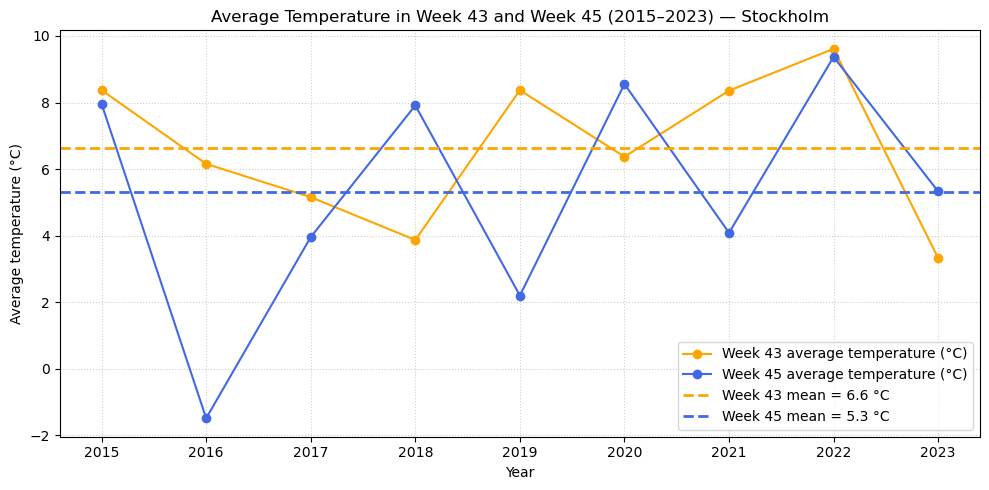

 Week 43 average temperature (2015–2023): 6.6 °C
 Week 45 average temperature (2015–2023): 5.3 °C

 Temperatures in week 43 and week 45 are very similar each year.
This suggests the week-43 → week-45 cycling drop is NOT driven by colder weather.


In [45]:
# Temperature in Week 43 and Week 45 each year (2015–2023)


# Filter weather data once (weeks 43 & 45, years 2015–2023)
temp_w = (
    weekly_weather
    .query("2015 <= year <= 2023 and week in [43, 45]")
    .copy()
)

# Pivot so week 43 and week 45 sit side by side
pivot_temp = (
    temp_w.pivot(index="year", columns="week", values="temp_mean")
           .rename(columns={43: "week43", 45: "week45"})
           .sort_index()
)

# Compute average temperature for each week
avg43 = pivot_temp["week43"].mean()
avg45 = pivot_temp["week45"].mean()

# Create the temperature trend plot
plt.figure(figsize=(10, 5))

# Week 43 line
plt.plot(
    pivot_temp.index,
    pivot_temp["week43"],
    marker="o",
    color="orange",
    label="Week 43 average temperature (°C)"
)

# Week 45 line
plt.plot(
    pivot_temp.index,
    pivot_temp["week45"],
    marker="o",
    color="royalblue",
    label="Week 45 average temperature (°C)"
)

# Horizontal average lines
plt.axhline(avg43, color="orange", linestyle="--", linewidth=2,
            label=f"Week 43 mean = {avg43:.1f} °C")
plt.axhline(avg45, color="royalblue", linestyle="--", linewidth=2,
            label=f"Week 45 mean = {avg45:.1f} °C")

plt.title("Average Temperature in Week 43 and Week 45 (2015–2023) — Stockholm")
plt.xlabel("Year")
plt.ylabel("Average temperature (°C)")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

plt.show()

print(f" Week 43 average temperature (2015–2023): {avg43:.1f} °C")
print(f" Week 45 average temperature (2015–2023): {avg45:.1f} °C")

print("\n Temperatures in week 43 and week 45 are very similar each year.")
print("This suggests the week-43 → week-45 cycling drop is NOT driven by colder weather.")


#### Do cycling volumes decrease because of the increase in rainfall?

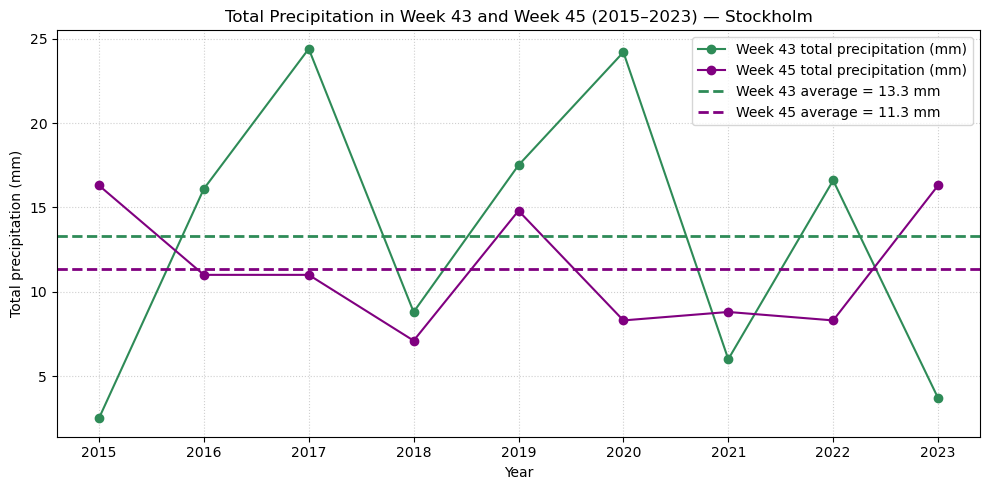

 Week 43 average precipitation (2015–2023): 13.3 mm
 Week 45 average precipitation (2015–2023): 11.3 mm

 Rainfall in week 43 and week 45 varies year-to-year,
but there is no consistent increase in week 45.
This supports the conclusion that the cycling drop from week 43 → 45
is not caused by precipitation differences.


In [46]:
# Precipitation in Week 43 and Week 45 (2015–2023) — Stockholm

precip_w = (
    weekly_weather
    .query("2015 <= year <= 2023 and week in [43, 45]")
    .copy()
)

# Pivot so both weeks appear side by side
pivot_precip = (
    precip_w.pivot(index="year", columns="week", values="precip_total")
            .rename(columns={43: "week43", 45: "week45"})
            .sort_index()
)

# Compute average precipitation for each week
avg43 = pivot_precip["week43"].mean()
avg45 = pivot_precip["week45"].mean()

# Create the plot (same structure as your original)
plt.figure(figsize=(10, 5))

# Week 43 line — green
plt.plot(
    pivot_precip.index,
    pivot_precip["week43"],
    marker='o',
    color='seagreen',
    label='Week 43 total precipitation (mm)'
)

# Week 45 line — purple
plt.plot(
    pivot_precip.index,
    pivot_precip["week45"],
    marker='o',
    color='purple',
    label='Week 45 total precipitation (mm)'
)

# Horizontal average lines
plt.axhline(avg43, color='seagreen', linestyle='--', linewidth=2,
            label=f'Week 43 average = {avg43:.1f} mm')
plt.axhline(avg45, color='purple', linestyle='--', linewidth=2,
            label=f'Week 45 average = {avg45:.1f} mm')

plt.title("Total Precipitation in Week 43 and Week 45 (2015–2023) — Stockholm")
plt.xlabel("Year")
plt.ylabel("Total precipitation (mm)")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

plt.show()

print(f" Week 43 average precipitation (2015–2023): {avg43:.1f} mm")
print(f" Week 45 average precipitation (2015–2023): {avg45:.1f} mm")

print("\n Rainfall in week 43 and week 45 varies year-to-year,")
print("but there is no consistent increase in week 45.")
print("This supports the conclusion that the cycling drop from week 43 → 45")
print("is not caused by precipitation differences.")


### 2.5 Effect of traffic environment on cycling level

#### Do cyclists avoid shared bike-pedestrian paths routes, particularly at night due to less visibility?

In [47]:
# Compute absolute drop using weekly_path


# Pivot to get week43 and week45 totals per path × year
abs_pivot = (
    weekly_path
    .pivot(index=['matplats_id', 'year'],
           columns='week',
           values='antal')
    .rename(columns={43: 'week43', 45: 'week45'})
)

# Restore matplats_id as column
abs_pivot = abs_pivot.reset_index()

# Replace zero values with NaN
abs_pivot[['week43', 'week45']] = abs_pivot[['week43', 'week45']].replace(0, np.nan)

# Drop rows where either week is missing (scientific validity)
abs_pivot = abs_pivot.dropna(subset=['week43', 'week45'])

abs_pivot['abs_drop'] = abs_pivot['week45'] - abs_pivot['week43']

# Average absolute drop across years (per path)
abs_drop_avg = (
    abs_pivot.groupby('matplats_id', as_index=False)['abs_drop']
             .mean()
)


# Merge absolute drop values into existing Top-20 table

avg_change_abs = avg_change.merge(abs_drop_avg, on='matplats_id', how='left')

# Convert to positive (for pie chart volume)
avg_change_abs['abs_drop'] = avg_change_abs['abs_drop'].abs()


# Compute share for bike–pedestrian path 6654
shared_path_id = 6654

sum_shared = avg_change_abs.loc[
    avg_change_abs['matplats_id'] == shared_path_id,
    'abs_drop'
].sum()

sum_other = avg_change_abs.loc[
    avg_change_abs['matplats_id'] != shared_path_id,
    'abs_drop'
].sum()


# Prepare pie chart input
pie_df = pd.DataFrame({
    "Group": [
        "Bike–Pedestrian Shared Path (6654)",
        f"Other Top-20 Paths ({len(avg_change_abs)-1})"
    ],
    "Drop": [sum_shared, sum_other]
})


fig = px.pie(
    pie_df,
    values="Drop",
    names="Group",
    title="Share of Total Cyclist Volume Drop (Absolute Numbers)\n"
          "Bike–Pedestrian Path (6654) vs. Other Top-20 Paths",
    color="Group",
    color_discrete_map={
        "Bike–Pedestrian Shared Path (6654)": "crimson",
        f"Other Top-20 Paths ({len(avg_change_abs)-1})": "steelblue"
    }
)

fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    pull=[0.12, 0]  # highlight bike–pedestrian path
)

fig.update_layout(showlegend=False, height=600)
fig.show()

total_drop = sum_shared + sum_other
share = (sum_shared / total_drop) * 100

print("\n===== ABSOLUTE DROP CONTRIBUTION =====")
print(f"Bike–pedestrian path drop: {sum_shared:,.0f} cyclists")
print(f"Other Top-20 paths drop: {sum_other:,.0f} cyclists")
print(f"Share of total drop from path 6654: {share:.1f}%")



===== ABSOLUTE DROP CONTRIBUTION =====
Bike–pedestrian path drop: 1,768 cyclists
Other Top-20 paths drop: 76,907 cyclists
Share of total drop from path 6654: 2.2%


#### Do cyclists avoid Side-by-side opposing cycle lanes, particularly at night due to less visibility?

In [48]:
# OPPOSING-CYCLE PATHS — Absolute Drop Contribution

# Build week43/week45 pivot WITHOUT injecting fake zeros
abs_pivot = (
    weekly_path
    .pivot(index=['matplats_id', 'year'], columns='week', values='antal')
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# Replace 0 → NaN (scientific validity: avoid treating device failures as real 0)
abs_pivot[['week43', 'week45']] = abs_pivot[['week43', 'week45']].replace(0, np.nan)

# Compute signed drop only where both weeks exist
abs_pivot['abs_drop'] = abs_pivot['week45'] - abs_pivot['week43']

# Compute average absolute drop per path (NaNs are automatically ignored)
abs_drop_avg = (
    abs_pivot.groupby('matplats_id', as_index=False)['abs_drop']
             .mean()
)


# Merge absolute drops into your Top-20 %-drop table
avg_change_abs = avg_change.merge(abs_drop_avg, on='matplats_id', how='left')

# Convert to positive values for pie chart area
avg_change_abs['abs_drop'] = avg_change_abs['abs_drop'].abs()


# Compute drop share for the opposing-cycle paths
opposing_ids = [6686, 6671, 6680]

sum_opposing = avg_change_abs.loc[
    avg_change_abs['matplats_id'].isin(opposing_ids),
    'abs_drop'
].sum()

sum_others = avg_change_abs.loc[
    ~avg_change_abs['matplats_id'].isin(opposing_ids),
    'abs_drop'
].sum()


# Prepare pie chart dataset
pie_df = pd.DataFrame({
    "Group": [
        "Opposing-cycle paths (3)",
        f"Other Top-20 paths ({len(avg_change_abs) - 3})"
    ],
    "Drop": [sum_opposing, sum_others]
})


# Draw pie chart (same visuals as before)
fig = px.pie(
    pie_df,
    values="Drop",
    names="Group",
    title="Share of Total Cyclist Volume Drop (Absolute Numbers)\n"
          "Opposing-cycle Paths vs. Other Top-20 Paths",
    color="Group",
    color_discrete_map={
        "Opposing-cycle paths (3)": "crimson",
        f"Other Top-20 paths ({len(avg_change_abs) - 3})": "steelblue"
    }
)

fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    pull=[0.12, 0]  # highlight opposing paths
)

fig.update_layout(showlegend=False, height=600)
fig.show()


total_drop = sum_opposing + sum_others
share = (sum_opposing / total_drop) * 100

print("\n===== ABSOLUTE DROP CONTRIBUTION =====")
print(f"Opposing-cycle paths total drop: {sum_opposing:,.0f} cyclists")
print(f"Other Top-20 paths total drop: {sum_others:,.0f} cyclists")
print(f"Share of total drop from opposing-cycle paths: {share:.1f}%")



===== ABSOLUTE DROP CONTRIBUTION =====
Opposing-cycle paths total drop: 10,954 cyclists
Other Top-20 paths total drop: 67,721 cyclists
Share of total drop from opposing-cycle paths: 13.9%


#### Do bidirectional cycle lanes experience lower cyclist volumes?

In [49]:
# Build week43/week45 pivot WITHOUT inserting fake zeros

abs_pivot = (
    weekly_path
    .pivot(index=['matplats_id', 'year'], columns='week', values='antal')
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# Replace sensor zeros with NaN for scientific correctness
abs_pivot[['week43', 'week45']] = abs_pivot[['week43', 'week45']].replace(0, np.nan)

# Compute year-by-year absolute drop (only where both exist)
abs_pivot['abs_drop'] = abs_pivot['week45'] - abs_pivot['week43']

abs_drop_avg = (
    abs_pivot.groupby('matplats_id', as_index=False)['abs_drop']
             .mean()
)

# Merge absolute drops into existing Top-20 %-drop table
avg_change_abs = avg_change.merge(abs_drop_avg, on='matplats_id', how='left')

avg_change_abs['abs_drop'] = avg_change_abs['abs_drop'].abs()


# Compute totals for bidirectional cycle paths
bidirectional_ids = [6632, 6657, 6688, 6633]

sum_bidirectional = avg_change_abs.loc[
    avg_change_abs['matplats_id'].isin(bidirectional_ids),
    'abs_drop'
].sum()

sum_others = avg_change_abs.loc[
    ~avg_change_abs['matplats_id'].isin(bidirectional_ids),
    'abs_drop'
].sum()


pie_df = pd.DataFrame({
    "Group": [
        "Bidirectional Cycle Paths (4)",
        f"Other Top-20 Paths ({len(avg_change_abs) - 4})"
    ],
    "Drop": [sum_bidirectional, sum_others]
})


fig = px.pie(
    pie_df,
    values="Drop",
    names="Group",
    title="Share of Total Cyclist Volume Drop (Absolute Numbers)\n"
          "Bidirectional Cycle Paths vs. Other Top-20 Paths",
    color="Group",
    color_discrete_map={
        "Bidirectional Cycle Paths (4)": "crimson",
        f"Other Top-20 Paths ({len(avg_change_abs) - 4})": "steelblue"
    }
)

fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    pull=[0.12, 0]
)

fig.update_layout(showlegend=False, height=600)
fig.show()


total_drop = sum_bidirectional + sum_others
share = (sum_bidirectional / total_drop) * 100

print("\n===== ABSOLUTE DROP CONTRIBUTION =====")
print(f"Bidirectional cycle paths total drop: {sum_bidirectional:,.0f} cyclists")
print(f"Other Top-20 paths total drop: {sum_others:,.0f} cyclists")
print(f"Share of total drop from bidirectional paths: {share:.1f}%")



===== ABSOLUTE DROP CONTRIBUTION =====
Bidirectional cycle paths total drop: 3,466 cyclists
Other Top-20 paths total drop: 75,209 cyclists
Share of total drop from bidirectional paths: 4.4%


### 3. Summary

The main research question was:

*How does cycling in Stockholm change once autumn break ends and the city becomes darker, colder, and busier?*

To explore this, the following analysis was performed:

- **overall cycling level:** Analyzed seasonal and yearly cycling volumes and how total activity varies across months and weeks.

- **effect of light on cycling level:** Analyzed cycling patterns in relation to daylight, sunrise/sunset times and route-specific responses to changing light conditions.

- **cycling routes changes:** Identified which routes lose the most cyclists and which maintain or increase volumes.

- **effect of weather on cycling level:** Analyzed temperature and precipitation data alongside cycling counts to explore how weather conditions relate to activity levels.

- **effect of traffic environment on cycling level:** Analyzed route characteristics such as lighting, separation, and infrastructure type in relation to changes in cycling volumes.


## Primary Conclusion
text
text
text

# Presentation ("Flipping the Pyramid")

## Executive Summary
text
text text

## 1. Key finding

## 2. Key finding

## 3. Key finding

## 4. Key finding